In [1]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import xml.etree.ElementTree as ET
from tqdm.auto import tqdm


In [2]:
# def filter_data(data, len_range, max_space):
#     if data["label"] is None:
#         return False
#     if len(data["label"]) < len_range[0] or len(data["label"]) > len_range[1]:
#         return False
#     if data["label"].count(' ') > max_space:
#         return False
#     if data["label"].isascii() == False:
#         return False    
#     for char in "\n\r\xad\xa0":
#         if char in data["label"]:
#             return False
#     return True

def filter_only_fonts(data):
    if data["image_path"].startswith("../../datasets/mjsynth/") == True:
        return False
    return True

def load_dataset(data_file_path, len_range, max_space, max_len=-1):
    dataset = []
    lines = open(data_file_path, "r").readlines()
    if max_len != -1:
        lines = lines[:max_len]
    for line in tqdm(lines):
        splitted_line = line.split(' ', 1)
        dataset.append({
            "image_path": splitted_line[0],
            "label": splitted_line[1].split('\n')[0]
        })
    # dataset = list(filter(lambda data: filter_data(data, len_range, max_space), dataset))
    return dataset

dataset = load_dataset("./data.txt", len_range=(3, 32), max_space=3, max_len=582_103*2)
# dataset = list(filter(filter_only_fonts, tqdm(dataset)))

  0%|          | 0/996791 [00:00<?, ?it/s]

In [3]:
print(len(dataset))
# For computer vision deep learning, there is a consensus saying that a dataset of 1000 labeled images for each classes is needed
image_paths = list(map(lambda data: data["image_path"], dataset))
labels = list(map(lambda data: data["label"].replace('|',  '\n'), dataset))
np.random.shuffle(dataset)

train_ds = dataset[:int(0.98*len(dataset))] #98% of the whole dataset is train dataset
validation_ds = dataset[int(0.98*len(dataset)):int(0.99*len(dataset))] #1% is  validation dataset
test_ds = dataset[int(0.99*len(dataset)):] #1% is test dataset


AUTOTUNE = tf.data.AUTOTUNE # Let tf decide the best tunning algos

characters = sorted(list(set(char for label in labels for char in label)))
max_len = len(max(labels, key=len))
print(max_len)
print(characters)
# Mapping characters to integer -> returns a function
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters -> returns a function
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

batch_size = 64
padding_token = 99
image_height = 64
image_width = image_height * 4

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path) # Open file with tf
    image = tf.image.decode_png(image, channels=1) # transform to matrix of gray scale value
    image = distortion_free_resize(image, img_size) # Distort image
    image = tf.cast(image, tf.float32) / 255.0 # Transform image to data into matrix of gray scale float32 values in range [0, 1]
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    return tf.data.Dataset.from_tensor_slices(
        (image_paths, labels)
    ).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    ).batch(batch_size)
    # return tf.data.Dataset.from_tensor_slices(
    #     (image_paths, labels)
    # ).map(
    #     process_images_labels, num_parallel_calls=AUTOTUNE
    # ).batch(batch_size).cache().prefetch(AUTOTUNE)

train_ds = prepare_dataset(list(map(lambda data: data["image_path"], train_ds)), list(map(lambda data: data["label"], train_ds)))
validation_ds = prepare_dataset(list(map(lambda data: data["image_path"], validation_ds)), list(map(lambda data: data["label"], validation_ds)))
test_ds = prepare_dataset(list(map(lambda data: data["image_path"], test_ds)), list(map(lambda data: data["label"], test_ds)))

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 128)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(128, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss", )(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    # opt = keras.optimizers.Adam()
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
#model.summary()
######## EVALUATION METRICS
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

epochs = 10  # To get good results this should be at least 50.
model.summary()
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

edit_distance_callback = EditDistanceCallback(prediction_model)

early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

CP_PATH = "./training/cp-{epoch:04d}.ckpt"
TEMP_CP_PATH = "TRAINING-ONLY-FONTS/cp-{epoch:04d}.ckpt"

# Create checkpoint
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CP_PATH,
    save_weights_only=True,
    verbose=1,
    # save_freq=5*batch_size #Only every 5 e^pochs
)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback, cp_callback],
)


996791
32
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None

KeyboardInterrupt: 

In [ ]:
### Save complte model after training
model.save('./saved_model/CNN-MODEL-V4')


INFO:tensorflow:Assets written to: ./saved_model/CNN-MODEL-V4\assets


INFO:tensorflow:Assets written to: ./saved_model/CNN-MODEL-V4\assets


2/2 [==============================] - 0s 276ms/step


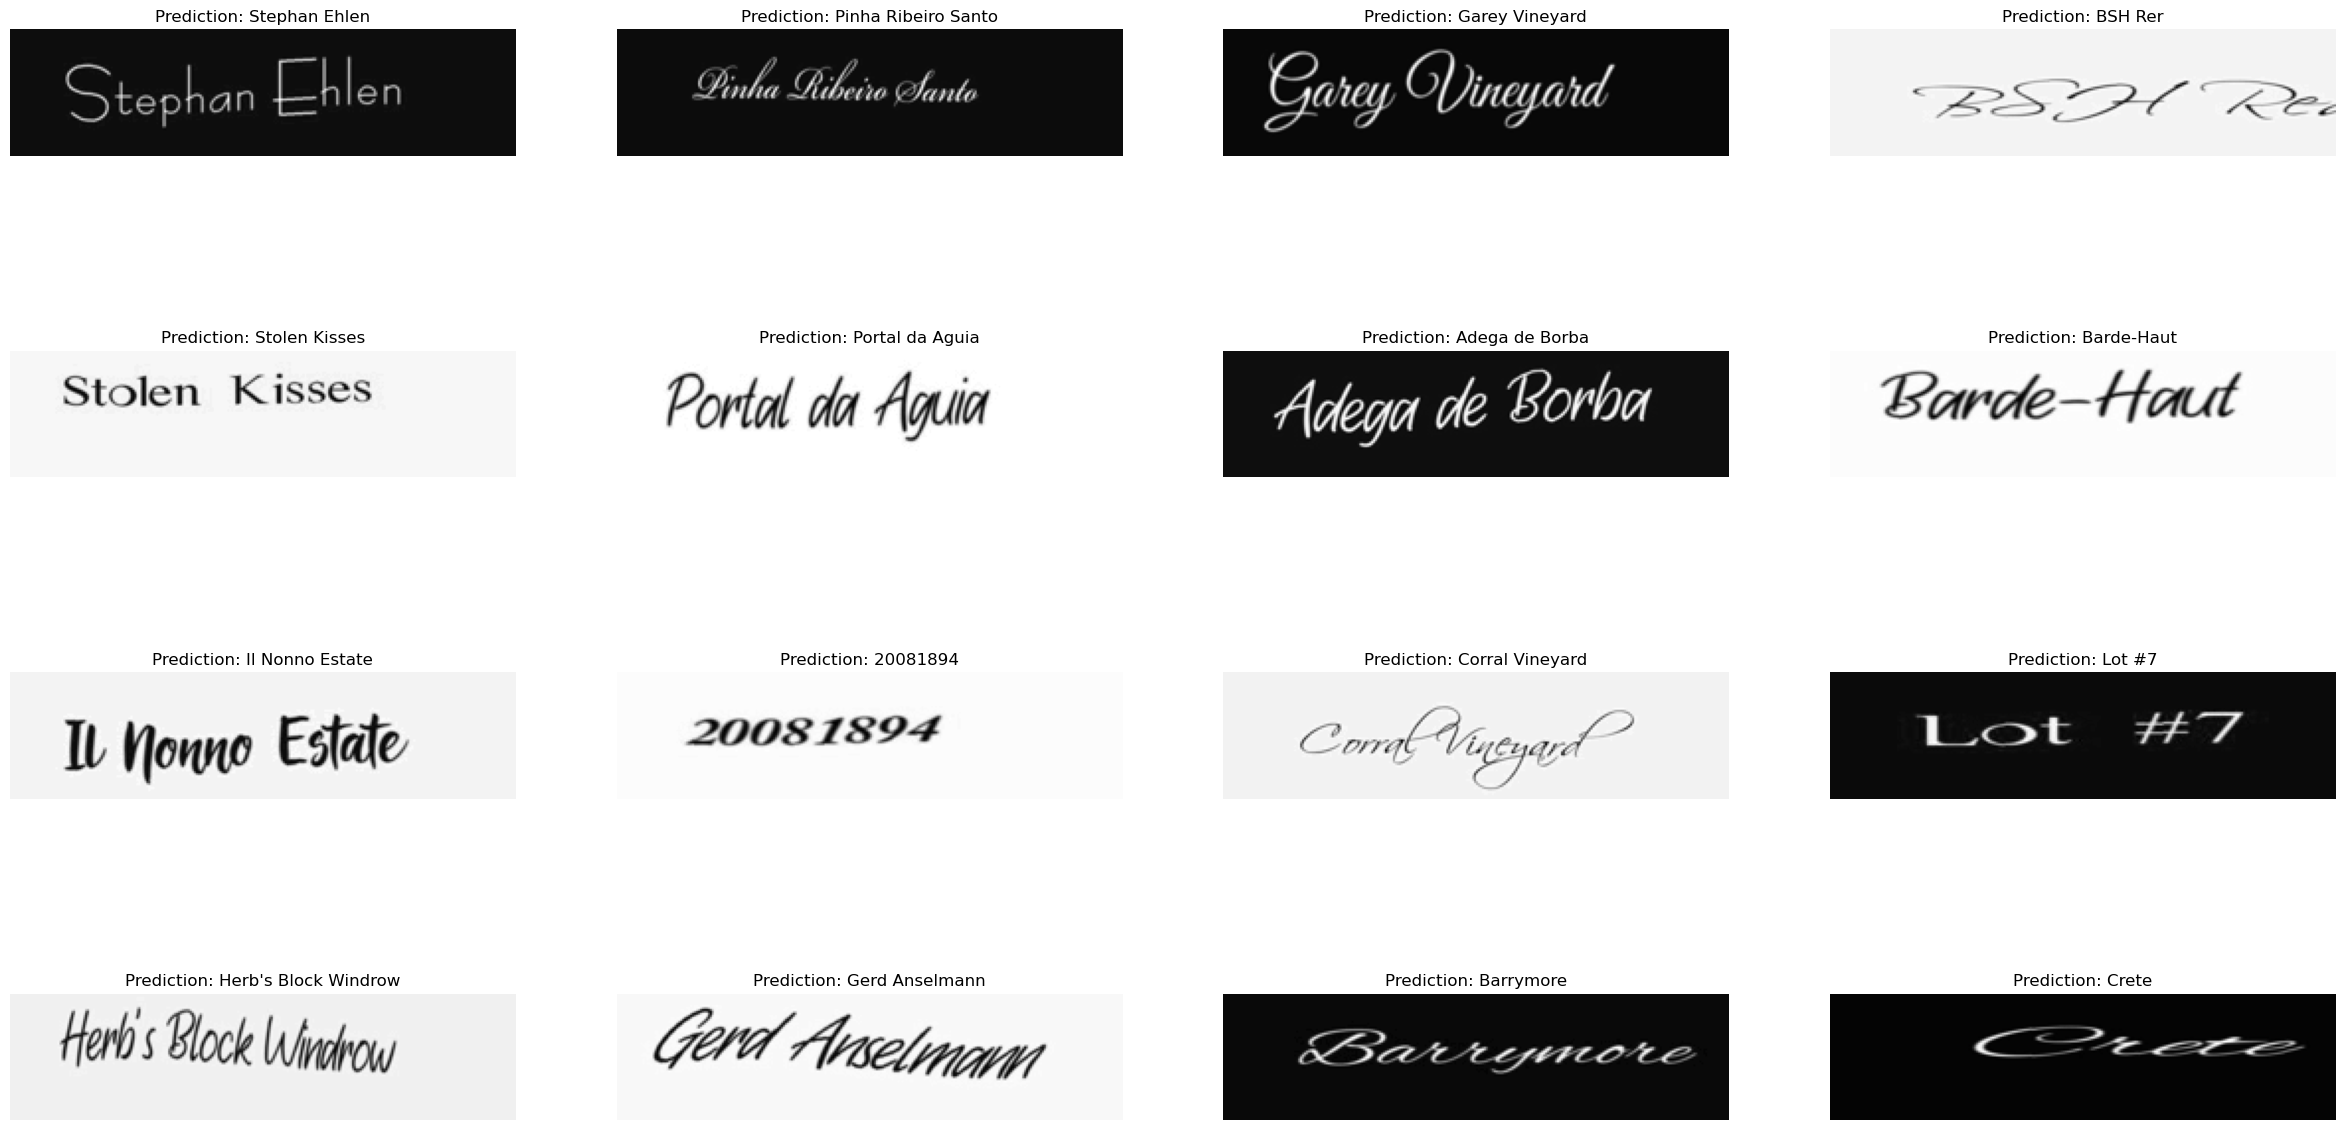

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_label = batch["label"]
    _, ax = plt.subplots(4, 4, figsize=(30, 16))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()